In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from datetime import datetime, timedelta
from scipy import stats
import statsmodels.api as sm
plt.style.use("seaborn-v0_8")

import warnings
warnings.filterwarnings('ignore')

## Step 1

#### Extend the PCA monitoring framework in lesson 4.3 with the goal of obtaining a systemic risk indicator combining signals of correlation breakdown and of widening credit spread


The computational framework adopted in lesson $\S \, 4.3$ made use of nine ETFs of the SPDR series, issued by State Street to target specific industry and service sectors in the economy, with each ETF composed exclusively of stocks that are within the S&P500 index.
The computations start from January 2007 and extend until the present date. 
That is why only the nine ETFs already existing in 2007, out of the full suite of eleven SPDR ETFs, were used in the analysis.

Beyond the SPDR ETFs, extra tickers were tracked to follow the volatility of the markets (^VIX), the 10-year Treasury bonds yields (^TNX), and an ETF from iShares reproducing the yield of investment grade corporate bonds (LQD).

All of the data series above are taken with a daily frequency at markets closing time.

Further, we gather daily yield series from the FRED database, for Baa investment grade $\geq 20$-year corporate bonds as graded by Moody's (BAA) and again the 10-year Treasury bond yields (DGS10).

To summarise:

| Ticker | Description |
|:------:|:------------|
| | **SPDR ETFs**
| `XLB`  | S&P500 Materials stocks |
| `XLE`  | S&P500 Energy stocks |
| `XLF`  | S&P500 Financial stocks |
| `XLI`  | S&P500 Industrial stocks |
| `XLK`  | S&P500 Technology stocks |
| `XLP`  | S&P500 Consumer Staples stocks |
| `XLU`  | S&P500 Utilities stocks |
| `XLV`  | S&P500 Healthcare stocks |
| `XLY`  | S&P500 Consumer Discretionary stocks |
| |**Other market data**
| `^VIX` | Market volatility index |
| `^TNX` | 10-year Treasury yields index|
| `LQD`  | Liquid, investment-grade corporate bond yields |
|  |**FRED data**
| `BAA`  | Moody's Baa-rated corporate bond yields |
| `DGS10`| 10-year Treasury yields |


Below, the shape of the `pandas` DataFrame for the 9 SPDR ETFs downloaded, sporting for dimensions the number of daily observations for the period 2007-2025 (after data cleaning) $\times$ the 9 ETFs.

In [2]:
# 11 Sector ETFs + VIX & 10‑yr yield for validation
sector_tickers = [
    "XLK", "XLF", "XLV", "XLE", "XLI", "XLY",
    "XLP", "XLB", "XLU"#, "^GSPC"
]
extra_tickers = ["^VIX", "^TNX", "LQD"] #"SP500BDT"]    # VIX and 10‑yr Treasury yield

start = "2007-01-04"
end = datetime.today() - timedelta(days=1)
end = end.strftime("%Y-%m-%d")
raw = pd.DataFrame(
    yf.download(sector_tickers + extra_tickers, start=start, end=end, progress=False, auto_adjust=True)
)["Close"]

# Drop rows with all‑NaNs (market holidays)
prices = raw.dropna(how="all")

# 1. Daily log‑returns
rets = pd.DataFrame(np.log(prices / prices.shift(1))).dropna()

# 2. Winsorise 4‑sigma tails (simple clip)
sigma4 = 4 * rets.std()
rets = rets.clip(lower=-sigma4, upper=sigma4, axis=1)

# 3. Selecting the sector returns
sector_rets = rets[sector_tickers]         # 9 × T matrix

print("Shape of downloaded market data of SPDR ETFs: ", sector_rets.shape)

Shape of downloaded market data of SPDR ETFs:  (4687, 9)


We see that the number of observations for the remaining data series extracted from markets agrees with the previous database at 4684 datapoints:

In [3]:
print("Shape of downloaded market data of volatility and fixed income indices: ", rets[["^VIX", "^TNX", "LQD"]].shape)

Shape of downloaded market data of volatility and fixed income indices:  (4687, 3)


FRED series `BAA`, although nominally taken with daily frequency as declared on the FRED website, in reality exhibits monthly frequency when extracted from the database.

In [4]:
fred = Fred(api_key="94fd20817a25e8215aa058f93235ba89")

fred.get_series_info("BAA")

id                                                                         BAA
realtime_start                                                      2025-08-21
realtime_end                                                        2025-08-21
title                                Moody's Seasoned Baa Corporate Bond Yield
observation_start                                                   1919-01-01
observation_end                                                     2025-07-01
frequency                                                              Monthly
frequency_short                                                              M
units                                                                  Percent
units_short                                                                  %
seasonal_adjustment                                    Not Seasonally Adjusted
seasonal_adjustment_short                                                  NSA
last_updated                                        

A workaround is found in downloading FRED's `DBAA` series instead, with the initial letter D evidently standing for *daily*.

Given that the Treasury yields data `DGS10` have more observations than all other series downloaded, in fact spanning over days when markets were closed, we will fill the missing datapoints in `DBAA` with the previous most recent observation available.

There also exist a FRED series `BAA10Y` = `DBAA` - `DGS10` which tracks the credit spread of investment-grade corporate bonds out of the box.
The graph below shows `BAA10Y` is obtained exactly as `DBAA` - `DGS10`.

In [5]:
fred_ids = {
    "DBAA"    : "DBAA",     # Moody Baa yield (% p.a.)
    "UST10"  : "DGS10",   # 10y Treasury yield (% p.a.)
    "BAA10Y" : "BAA10Y"
}

fred_data = pd.concat({k: fred.get_series(v, observation_start=start, observation_end=end)
                  for k, v in fred_ids.items()}, axis=1).ffill().dropna()

print("Shape of spread data from Fred: ", fred_data.shape)

Shape of spread data from Fred:  (4865, 3)


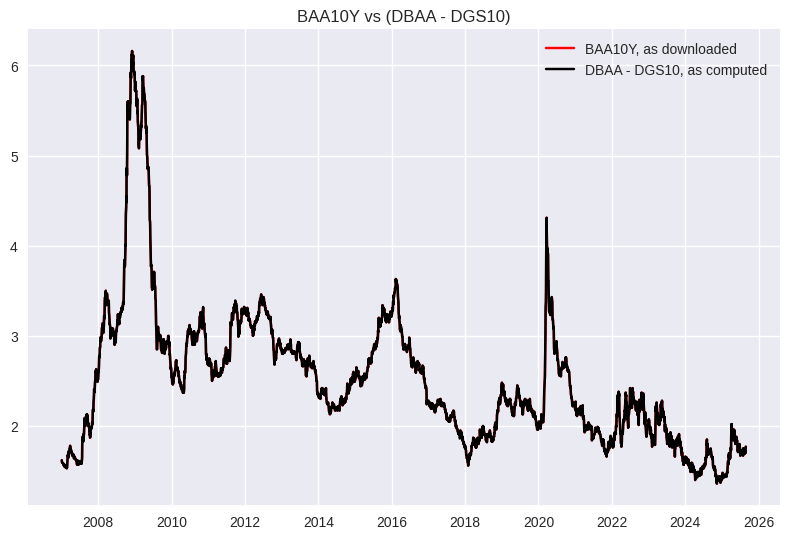

In [6]:
# check BAA10Y is exactly DBAA - DGS10
fig, ax = plt.subplots()
ax.plot(fred_data.index, fred_data["BAA10Y"], 'r', label="BAA10Y, as downloaded")
ax.plot(fred_data.index, fred_data["DBAA"] - fred_data["UST10"], 'k', label="DBAA - DGS10, as computed")
plt.title("BAA10Y vs (DBAA - DGS10)")
plt.legend()
plt.tight_layout()
plt.show()

For the sake of comparing the credit spread obtained from FRED data (`BAA10Y`) with the one obtained from market data (`LQD` - `^TNX`), we first adapt the former to have the same number of observations of the latter.

In [7]:
# Credit spread in decimal form
spread_fred = pd.Series(data=fred_data["BAA10Y"] / 100, index=sector_rets.index, name="Credit Spread from FRED") # from % to decimal per annum
spread_market = pd.Series(data=abs(rets["LQD"] - rets["^TNX"]), index=sector_rets.index, name="Credit Spread from markets").ffill()
print("shape of spread data from markets: ", spread_market.shape)

shape of spread data from markets:  (4687,)


In [8]:
print("shape of spread data from FRED: ", spread_fred.shape)

shape of spread data from FRED:  (4687,)


The credit spreads so obtained by two different sources are plotted in the figure below.

It is evident that the market measure (blue) is much more noisy than that obtained from FRED data (red).
We attribute this to the nature of `LQD` as a liquid (highly traded) instrument.
Its price is determined by supply and demand dynamics, rather than by the yields of the corporate bonds undergirding it.
In turn, this price will reflect the bonds' yields, but only indirectly through market participants' behaviour.

In support of the previous observation, we observe that the absolute value of the noisy market data seems to follow the same patterns as the more regular FRED data.
The two measures of credit spread seem to be correlated.

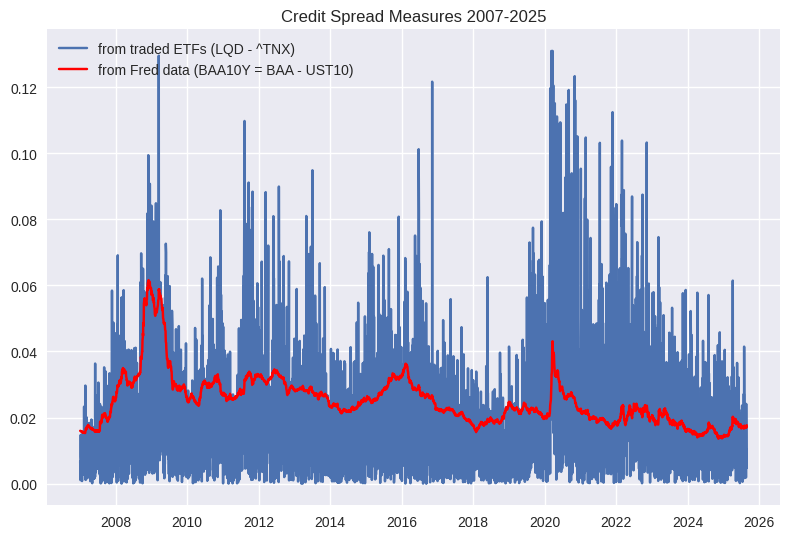

In [9]:
fig = plt.figure()
plt.plot(spread_market.index, spread_market, label="from traded ETFs (LQD - ^TNX)")
plt.plot(spread_fred.index, spread_fred, color='r', label="from Fred data (BAA10Y = BAA - UST10)")
plt.legend()
plt.title("Credit Spread Measures 2007-2025")
plt.tight_layout()
plt.show()

Now, in order to observe the correlations amongst the SPDR ETFs during the selected 2007-25 time window, we compute rolling correlation matrices for time windows of 60 trading days, advancing one day at the time.

The spectral decomposition (or PCA) of these rolling correlation matrices will yield the eigenvalues of the matrices.
The largest eigenvalue is found to represent the *market factor* that affects all securities, determining parallel shifts in stock prices.

Its *explained variance ratio* (EVR), i.e. the fraction of total portfolio variance it explains, grows in times of increased market uncertainty.
This consists in an undesirable increase in global correlation that could be exploited as a signal for a possibly incipient financial crisis.

In [10]:
def rolling_pca(returns, correlation_type, window=60):
    """
    correlation_type : str, choose among 'pearson', 'spearman' and 'kendall'
    returns : DataFrame (T x N) of zero-mean daily returns
    returns, evr        : DataFrame indexed by window end-date
    loadings_list       : list of Γ matrices (N x N) per window
    """

    evr_list, score_list, loadings_list = [], [], []
    idx = returns.index

    for t in range(window - 1, len(idx)):
        X = returns.iloc[t - window + 1 : t + 1]
        # C = np.corrcoef(X.T)                         # 11×11
        C = X.corr(method=correlation_type)
        vals, vecs = np.linalg.eigh(C)               # ascending

        # Sort descending and fix PC1 sign so XLK loading positive
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        if vecs[sector_tickers.index("XLK"), 0] < 0:
            vecs[:, 0] *= -1
        # Same procedure for PC2 & PC3 if desired (not necessary)

        evr_list.append(vals / vals.sum())
        loadings_list.append(vecs)
        score_list.append(vecs.T @ returns.iloc[t].values)

    dates = idx[window - 1 :]
    evr = pd.DataFrame(evr_list, index=dates,
                       columns=[f"EVR{k}" for k in range(1, len(returns.columns)+1)])
    scores = pd.DataFrame(score_list, index=dates,
                          columns=[f"PC{k}_score" for k in range(1, len(returns.columns)+1)])
    return evr, scores, loadings_list

We have updated the code in lesson $\S 4.3$ to compute the rolling correlation matrices to include not just computing the Pearson (linear) correlation, but also Spearman and Kendall correlations, to track nonlinear effects.

Below, we show the three correlation matrices for the 9 SPDR ETFs, not limited to a few days rolling window, but across the whole time period 2007-25:

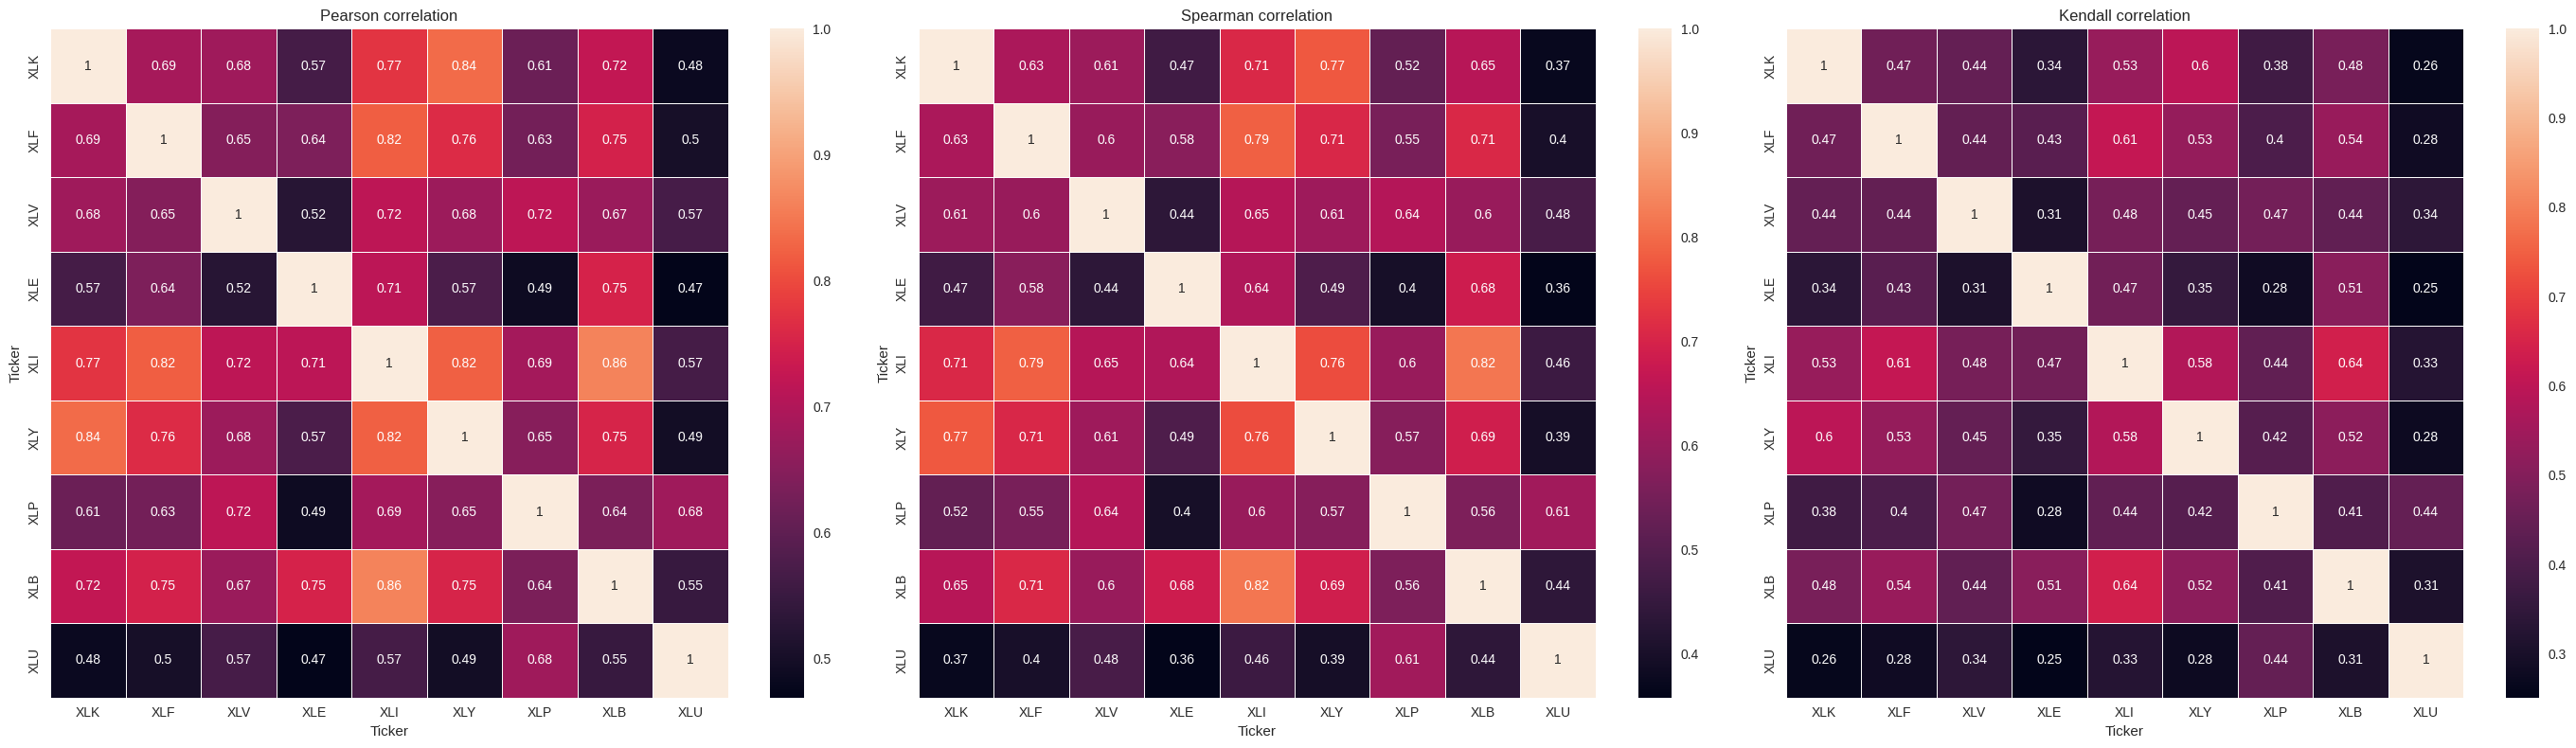

In [11]:
C_pearson = pd.DataFrame(np.corrcoef(sector_rets.T), index=sector_rets.columns, columns=sector_rets.columns)
# spearman correlation
C_spearman = sector_rets.corr(method='spearman')
# kendall correlation
C_kendall = sector_rets.corr(method='kendall')

fig, ax = plt.subplots(1, 3, squeeze=False, figsize=(28, 8))
ax1 = sns.heatmap(C_pearson, annot=True, linewidth=.5, ax=ax[0,0])
ax2 = sns.heatmap(C_spearman, annot=True, linewidth=.5, ax=ax[0,1])
ax3 = sns.heatmap(C_kendall, annot=True, linewidth=.5, ax=ax[0,2])
ax1.set(title="Pearson correlation")
ax2.set(title="Spearman correlation")
ax3.set(title="Kendall correlation")

plt.tight_layout()
plt.show()

We can see from the colorbars in the figures above, showing extreme values, that if nonlinear effects are included (Spearman and Kendall matrices), then the 9 ETFs are overall less correlated than the linear correlation matrix (Pearson) would imply.

Next, from the rolling 60-days correlations of returns, we compute the EVR for the first eigenvalue (EVR1).
We do it for each of the Pearson, Spearman and Kendall correlation matrices.

Notice how, on an average home workstation, the computational cost of obtaining the rolling Kendall correlations with Python is $20 \times$ more expensive than with the other methods.

| Correlation | Elapsed computation time ($s$) |
|:--|:--:|
| Pearson | 2.4 |
| Spearman | 3.9 |
| Kendall | 84.5 |

In [12]:
# Pearson EVR
evr_pearson, pcscores_pearson, _ = rolling_pca(sector_rets, 'pearson', window=60)

EVR1_pearson = evr_pearson["EVR1"]
PC2_z_pearson = (pcscores_pearson["PC2_score"]
         .rolling(120).apply(lambda x: (x.iloc[-1] - x.mean()) / x.std(),
                             raw=False))
PC3_score_pearson = pcscores_pearson["PC3_score"]

vix = prices["^VIX"].loc[EVR1_pearson.index]
tnx = prices["^TNX"].loc[EVR1_pearson.index] / 100        # ^TNX quote is yield×100

In [13]:
# Spearman EVR
evr_spearman, pcscores_spearman, _ = rolling_pca(sector_rets, 'spearman', window=60)

EVR1_spearman = evr_spearman["EVR1"]
PC2_z_spearman = (pcscores_spearman["PC2_score"]
         .rolling(120).apply(lambda x: (x.iloc[-1] - x.mean()) / x.std(),
                             raw=False))
PC3_score_spearman = pcscores_spearman["PC3_score"]

In [14]:
# Kendall EVR
evr_kendall, pcscores_kendall, _ = rolling_pca(sector_rets, 'kendall', window=60)

EVR1_kendall = evr_kendall["EVR1"]
PC2_z_kendall = (pcscores_kendall["PC2_score"]
         .rolling(120).apply(lambda x: (x.iloc[-1] - x.mean()) / x.std(),
                             raw=False))
PC3_score_kendall = pcscores_kendall["PC3_score"]

From plotting these EVR1s (blue) against time, and in comparison with the ^VIX index (gray), we observe that the EVR1 signal obtained from the Kendall correlation is much more conservative than the previous two.
It crosses the highest threshold of correlation (red dotted line) only in three occasions: 2010, 2011-12, and 2020.

It is noticeable that, contrary to the other two correlation methods, the Kendall correlation signal missed the 2007-08 Quant Crash and Great Financial Crisis.

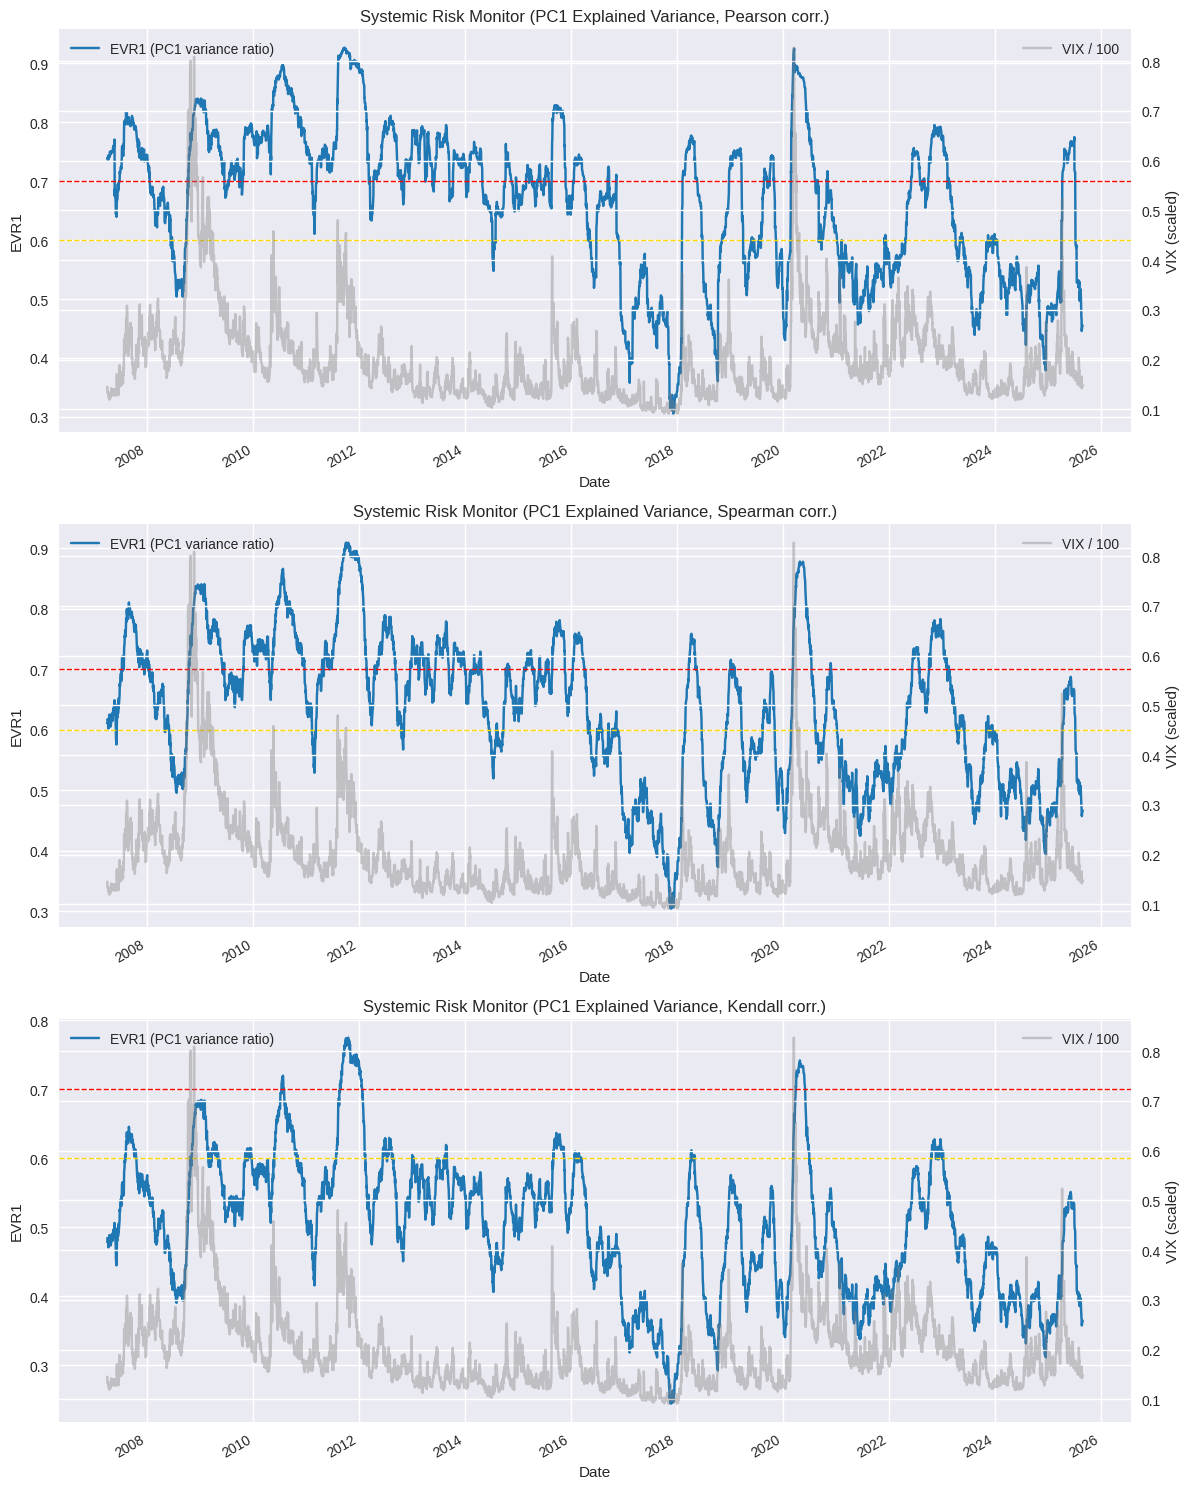

In [15]:
fig, ax1 = plt.subplots(3, 1, squeeze=False, figsize=(12,15))

# Pearson
EVR1_pearson.plot(ax=ax1[0,0], color="tab:blue", label="EVR1 (PC1 variance ratio)")
ax1[0,0].axhline(0.60, ls="--", color="gold", lw=1)
ax1[0,0].axhline(0.70, ls="--", color="red", lw=1)
ax1[0,0].set(ylabel="EVR1", title="Systemic Risk Monitor (PC1 Explained Variance, Pearson corr.)")
ax2_pearson = ax1[0,0].twinx()
(vix/100).plot(ax=ax2_pearson, color="tab:gray", alpha=0.4, label="VIX / 100")
ax2_pearson.set_ylabel("VIX (scaled)")
ax1[0,0].legend(loc="upper left"); ax2_pearson.legend(loc="upper right")

# Spearman
EVR1_spearman.plot(ax=ax1[1,0], color="tab:blue", label="EVR1 (PC1 variance ratio)")
ax1[1,0].axhline(0.60, ls="--", color="gold", lw=1)
ax1[1,0].axhline(0.70, ls="--", color="red", lw=1)
ax1[1,0].set(ylabel="EVR1", title="Systemic Risk Monitor (PC1 Explained Variance, Spearman corr.)")
ax2_spearman = ax1[1,0].twinx()
(vix/100).plot(ax=ax2_spearman, color="tab:gray", alpha=0.4, label="VIX / 100")
ax2_spearman.set_ylabel("VIX (scaled)")
ax1[1,0].legend(loc="upper left"); ax2_spearman.legend(loc="upper right")

# Kendall
EVR1_kendall.plot(ax=ax1[2,0], color="tab:blue", label="EVR1 (PC1 variance ratio)")
ax1[2,0].axhline(0.60, ls="--", color="gold", lw=1)
ax1[2,0].axhline(0.70, ls="--", color="red", lw=1)
ax1[2,0].set(ylabel="EVR1", title="Systemic Risk Monitor (PC1 Explained Variance, Kendall corr.)")
ax2_kendall = ax1[2,0].twinx()
(vix/100).plot(ax=ax2_kendall, color="tab:gray", alpha=0.4, label="VIX / 100")
ax2_kendall.set_ylabel("VIX (scaled)")
ax1[2,0].legend(loc="upper left"); ax2_kendall.legend(loc="upper right")

plt.tight_layout()
plt.show()

The next step of the analysis consists in checking whether credit spreads and our EVR1 signal are correlated.
It would be expected they are as credit spreads widen during systemic crises, just as the proportion of variance explained by the first eigenvalue (EVR1) grows larger.

We have two measures of credit spread, one coming from the FRED database and the other downloaded from the markets (LQD ticker as stand-in for corporate bonds), so we have to select the one better attuned to the EVR1 dataset.

For this purpose, we are going to proceed with a linear regression of the Pearson correlation EVR1 data with both the databases of credit spread at our disposal.

In [16]:
# linear regression PeaRSON EVR vs credit spreads,
Y = spread_market.loc["2007-04-02":]  # dependent variable (annual intensity)
X = evr_pearson[["EVR1", "EVR2", "EVR3"]]
X = sm.add_constant(X)   # intercept

ols = sm.OLS(Y, X).fit()
print(ols.summary())

                                OLS Regression Results                                
Dep. Variable:     Credit Spread from markets   R-squared:                       0.060
Model:                                    OLS   Adj. R-squared:                  0.060
Method:                         Least Squares   F-statistic:                     98.88
Date:                        Fri, 29 Aug 2025   Prob (F-statistic):           4.94e-62
Time:                                00:47:34   Log-Likelihood:                 12071.
No. Observations:                        4628   AIC:                        -2.413e+04
Df Residuals:                            4624   BIC:                        -2.411e+04
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

<AxesSubplot: xlabel='EVR1', ylabel='Credit Spread from markets'>

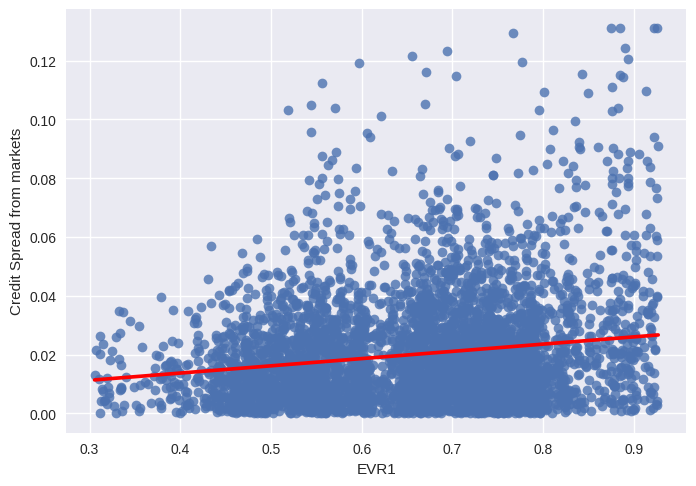

In [17]:
# plot regression
evr_pearson_spread_df = pd.concat([evr_pearson, spread_market], axis=1)
sns.regplot(x='EVR1', y='Credit Spread from markets', data=evr_pearson_spread_df, x_ci="ci", marker="o", scatter=True, line_kws=dict(color="r"), ci=None)

P-values $=0$ for the EVR1-2-3 coefficients in the regression are encouraging, however a low value for the $R^2$ statistic $=0.060$ on the contrary signals that a very low proportion of the total variance of the dependent variable, the credit spread, is explained by the EVR coefficients.

Therefore, we record a mixed outcome for this regression.

Next, much better results are obtained by regressing the EVR measure against the credit spread series from FRED:

In [18]:
# linear regression Pearson EVR vs Fred credit spreads
Y = spread_fred.loc["2007-04-02":].ffill()  # dependent variable (annual intensity)
X = evr_pearson[["EVR1", "EVR2", "EVR3"]]
X = sm.add_constant(X)   # intercept

ols_fred = sm.OLS(Y, X).fit()
print(ols_fred.summary())

                               OLS Regression Results                              
Dep. Variable:     Credit Spread from FRED   R-squared:                       0.296
Model:                                 OLS   Adj. R-squared:                  0.296
Method:                      Least Squares   F-statistic:                     648.9
Date:                     Fri, 29 Aug 2025   Prob (F-statistic):               0.00
Time:                             00:47:35   Log-Likelihood:                 16657.
No. Observations:                     4628   AIC:                        -3.331e+04
Df Residuals:                         4624   BIC:                        -3.328e+04
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

Text(0.5, 1.0, 'EVR1 from Spearman correlation vs Credit Spreads')

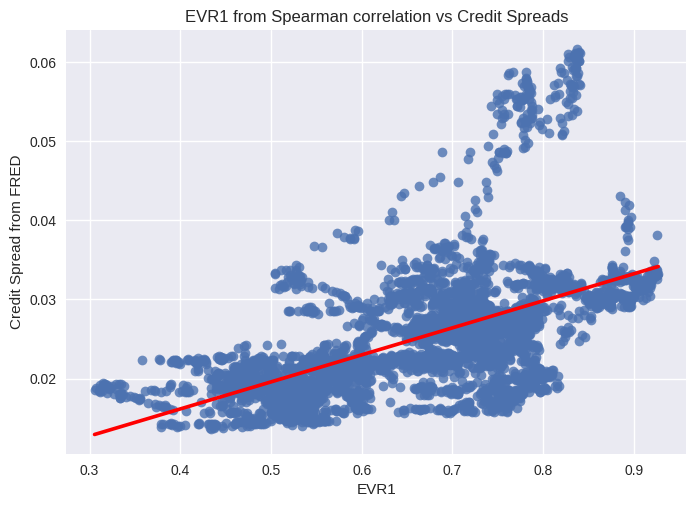

In [19]:
# plot regression
evr_pearson_spread_fred_df = pd.concat([evr_pearson, spread_fred], axis=1)
sns.regplot(x='EVR1', y='Credit Spread from FRED', data=evr_pearson_spread_fred_df, x_ci="ci", marker="o", scatter=True, line_kws=dict(color="r"), ci=None)
plt.title("EVR1 from Spearman correlation vs Credit Spreads")

Now the $R^2$ statistics is more solid, and at the same time the EVR1 coefficient estimation shows a solid p-stat score.

From this information we can infer that credit spreads from Fred are more dependable than their market counterpart, obtained from the LQD ETF.

Proceeding, we complete the picture with the next two regressions which will help selecting the most accurate correlation method for EVR1, in terms of how good it relates to the Fred credit spread.

In [20]:
# linear regression EVR (from Spearman corr) vs fred credit spreads
Y = spread_fred.loc["2007-04-02":].ffill()  # dependent variable (annual intensity)
X = evr_spearman[["EVR1", "EVR2", "EVR3"]]
X = sm.add_constant(X)   # intercept

ols_spearman = sm.OLS(Y, X).fit()
print(ols_spearman.summary())

                               OLS Regression Results                              
Dep. Variable:     Credit Spread from FRED   R-squared:                       0.347
Model:                                 OLS   Adj. R-squared:                  0.346
Method:                      Least Squares   F-statistic:                     818.3
Date:                     Fri, 29 Aug 2025   Prob (F-statistic):               0.00
Time:                             00:47:35   Log-Likelihood:                 16829.
No. Observations:                     4628   AIC:                        -3.365e+04
Df Residuals:                         4624   BIC:                        -3.362e+04
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

Text(0.5, 1.0, 'EVR1 from Spearman correlation vs Credit Spreads')

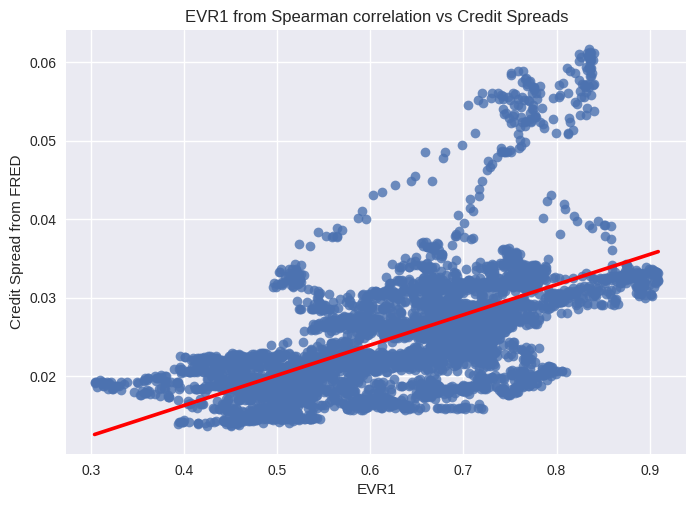

In [21]:
# plot regression
evr_spread_spearman_df = pd.concat([evr_spearman, spread_fred], axis=1)
sns.regplot(x='EVR1', y='Credit Spread from FRED', data=evr_spread_spearman_df, x_ci="ci", marker="o", scatter=True, line_kws=dict(color="r"), ci=None)
plt.title("EVR1 from Spearman correlation vs Credit Spreads")

In [22]:
# linear regression EVR (from Kendall corr) vs fred credit spreads
Y = spread_fred.loc["2007-04-02":].ffill()  # dependent variable (annual intensity)
X = evr_kendall[["EVR1", "EVR2", "EVR3"]]
X = sm.add_constant(X)   # intercept

ols_kendall = sm.OLS(Y, X).fit()
print(ols_kendall.summary())

                               OLS Regression Results                              
Dep. Variable:     Credit Spread from FRED   R-squared:                       0.349
Model:                                 OLS   Adj. R-squared:                  0.349
Method:                      Least Squares   F-statistic:                     826.2
Date:                     Fri, 29 Aug 2025   Prob (F-statistic):               0.00
Time:                             00:47:36   Log-Likelihood:                 16837.
No. Observations:                     4628   AIC:                        -3.367e+04
Df Residuals:                         4624   BIC:                        -3.364e+04
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

Text(0.5, 1.0, 'EVR1 from Kendall correlation vs Credit Spreads')

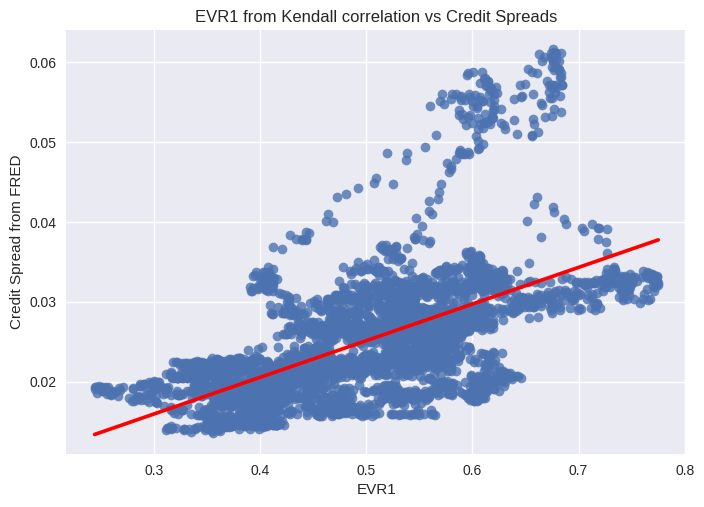

In [23]:
# plot regression
evr_spread_kendall_df = pd.concat([evr_kendall, spread_fred], axis=1)
sns.regplot(x='EVR1', y='Credit Spread from FRED', data=evr_spread_kendall_df, x_ci="ci", marker="o", scatter=True, line_kws=dict(color="r"), ci=None)
plt.title("EVR1 from Kendall correlation vs Credit Spreads")

All three correlation methods, Pearson, Spearman and Kendall, achieve a p-statistic $=0$ for the EVR1 coefficient.
Values of the $R^2$ statistic for Spearman and Kendall are better than Pearson's and more or less equal to each other. 
The standard error of the EVR1 coefficient in Spearman is slightly lower than Kendall's.

| Correlation | EVR1 coefficient | $R^2$ | EVR1 p-stat | EVR1 std err |
|:---|:---:|:---:|:---:|:---:|
| Pearson | 0.0364 | 0.296 | 0 | 0.003|
| Spearman | 0.0389 |  0.346 | 0 | 0.002|
| Kendall | 0.0481 | 0.349 | 0 | 0.003|

This, and additionally the previous observation that historical data for EVR1 from Kendall correlation is much more conservative and as such detects less false positives (good) due to noise, but also true positives (bad) such as the 2008 financial crisis, leads us to choose the Spearman correlation as our methodology to extract the EVR1 signal.

#### Generate a Systemic Risk Indicator (SRI) from correlation breakdown and widening credit spreads

An obvious observation that can be made of the above procedure that led us to pick the Spearman correlation matrix to generate the EVR1 metric, is that we applied linear regressions over a correlation measure that tracks nonlinearities.

The analysis would greatly benefit from employing Machine Learning in stead of linear regression to track these nonlinearities, at the price of course of more obfuscation in the selection process.

Indeed, the (Spearman EVR1 - credit spread) linear regression coefficient of 0.0389 is quite feeble, but this also might help justifying the construction of a SRI as linear combination of EVR1 and credit spread.
The two terms are expected to correlate more heavily during crises, while a linear combination-based SRI would instead suggest EVR1 and credit spread to be independent from each other.
However, a weak correlation when markets are placid might make an acceptable proxy for independence, while the linear combination will still cause the SRI to increase at market phase shifts, just more so than if the rising (EVR1-credit spreads) correlation were to be taken into account.

Therefore, we could define the SRI as following

$$\text{SRI}(\text{credit spread}, \text{EVR1}) = \alpha \cdot \text{credit spread} + \beta \cdot \text{EVR1}$$

where coefficients $\alpha , \, \beta$ could be selected from a Least Squares minimisation procedure.

The sum of squared residuals $\Delta$ to minimise might be the distance of the SRI from the ^VIX index, as volatility increases during crises, and our goal is to generate an indicator of crises.

$$\Delta = \sum_i \lVert \text{SRI}_i - \text{VIX}_i \rVert^2 $$

For each observation $i \in [2007, 2025]$ inside the selected timeframe.

We use the `curve_fit` method from `scipy` (based on nonlinear least squares) to calibrate the parameters $\alpha$ and $\beta$ in SRI.
The ^VIX index returns have higher order of magnitude, hence we are going to fit against $\frac{\text{VIX}}{100}$.

In [24]:
from scipy.optimize import curve_fit

In [25]:
def SRI(input, alpha, beta):
  spread = input.iloc[:,0].to_numpy()
  EVR1 = input.iloc[:,1].to_numpy()
  
  return alpha * spread + beta * EVR1

In [26]:
aggregated_data = pd.concat([spread_fred.loc["2007-04-02":], EVR1_spearman], axis=1)

popt, pcov, infodict, mesg, ier = curve_fit(SRI, aggregated_data, vix/100, bounds=(0., 10.), full_output=True)
print("alpha and beta coefficients: ", popt)

alpha and beta coefficients:  [6.27575756 0.0663326 ]


In [27]:
# stddev of coefficients
perr = np.sqrt(np.diag(pcov))
print("stddev of alpha and beta coefficients: ", perr)

stddev of alpha and beta coefficients:  [0.15482733 0.00635288]


The procedure yields values of

$$\begin{aligned}
\alpha = 6.276 \pm 0.155\\
\beta = 0.066 \pm 0.006
\end{aligned}$$

This is in line with credit spreads being much smaller in absolute value than the first explained variance of the correlation matrix of returns.

Graphically, the SRI is represented against the ^VIX, below:

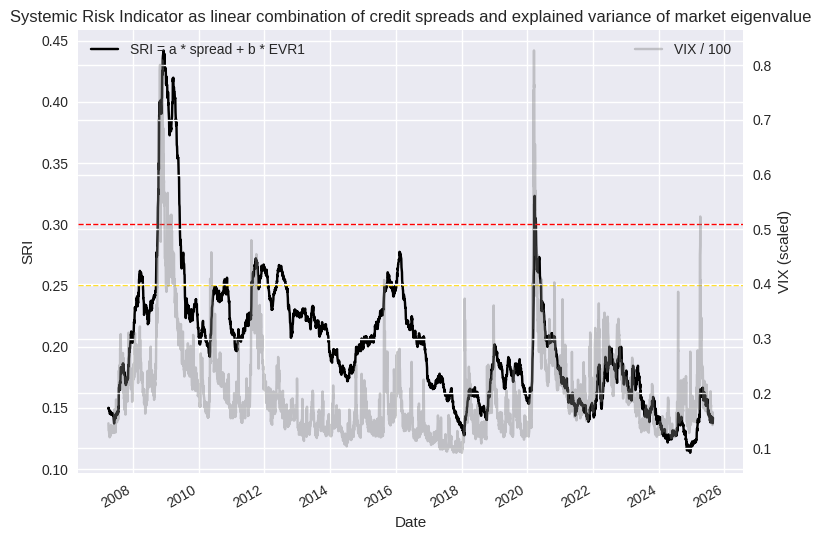

In [28]:
# SRI
popt_tot = np.sum(popt)
alpha = popt[0] #/ popt_tot
beta = popt[1] #/ popt_tot
SRI = alpha * spread_fred + beta * EVR1_spearman

fig, ax1 = plt.subplots()

SRI.plot(ax=ax1, color="k", label="SRI = a * spread + b * EVR1")
ax1.axhline(0.25, ls="--", color="gold", lw=1)
ax1.axhline(0.3, ls="--", color="red", lw=1)
ax1.set(ylabel="SRI", title="Systemic Risk Indicator as linear combination of credit spreads and explained variance of market eigenvalue")
ax2 = ax1.twinx()
(vix/100).plot(ax=ax2, color="tab:gray", alpha=0.4, label="VIX / 100")
ax2.set_ylabel("VIX (scaled)")
ax1.legend(loc="upper left"); ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

Predictably, the SRI mimics well the ^VIX during calm periods.

Outlier values observed during stormy financial periods present a small reaction lag with respect to ^VIX.
The financial crisis of 2008 is timely identified by the SRI in the whole of its intensity.
Not so much for other periods, like the Covid 2020 crisis, or the increase in US foreign tariff during the first half of 2025.
In these cases, the SRI emits tenuous signals when compared to ^VIX.
This is why the crisis thresholds were lowered to $0.3 \cdot \text{SRI}$ (red) and $0.25 \cdot \text{SRI}$ (yellow).


### Part B — Quantile Regression with Time‑Varying Correlation
Uses the common loader’s variables to fit rolling **Quantile Regression** for $\tau \in \{0.10, 0.05, 0.01\}$ and produce evaluation metrics and figures, all clipped to **2018‑04‑03 -> 2023‑12‑31**.

Rolling QR with correlation features adapts, but big regime jumps (like COVID) still cause short-term underestimation. Consider adding a fast-moving volatility proxy (e.g., 21-day realized vol), and include $\frac{\Delta \text{EVR1}}{\Delta \rho}$ to catch rapid correlation shifts.

Higher common-correlation regimes (peaks in 2020, 2023) coincide with periods where left-tail risk is larger, matching the wider/ more negative QR quantiles on the returns chart.

[INFO] EVR_WINDOW=63  RHO_WINDOW=63  QR_ROLL_WIN=126
[INFO] EVR1 starts:   2018-07-02 00:00:00 | rho_bar starts: 2018-07-02 00:00:00
[INFO] X starts:      2018-07-05 00:00:00
[INFO] Effective QR window used: 126
[INFO] First OOS pred: 2019-01-07 00:00:00 | OOS points: 1255
tau=0.10  pinball=0.001311  Kupiec(LR,p)=(83.90170871196904,0.0)  Christoffersen(LR,p)=(-21.00243140767132,1.0)
tau=0.05  pinball=0.001060  Kupiec(LR,p)=(190.4456892544049,0.0)  Christoffersen(LR,p)=(-21.657981888211363,1.0)
tau=0.01  pinball=0.000810  Kupiec(LR,p)=(641.9116844342548,0.0)  Christoffersen(LR,p)=(-19.354953346983585,1.0)


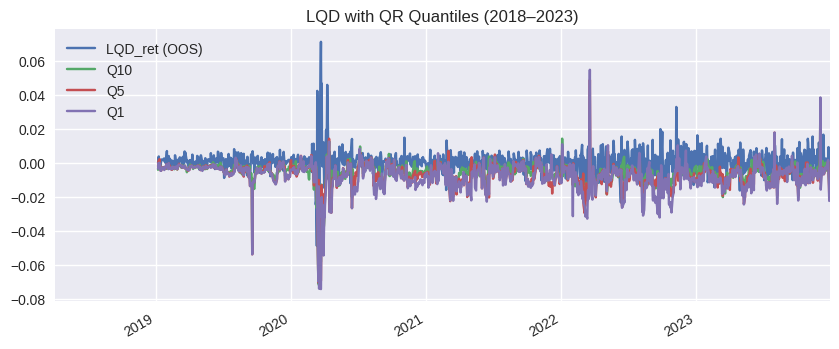

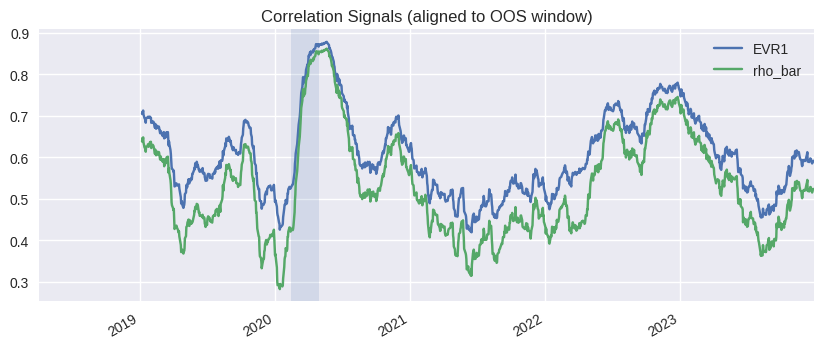

In [ ]:

# ==== Part B — Smaller windows so OOS begins earlier (Approach B) ====

import numpy as np, pandas as pd, matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
from scipy.stats import chi2

# TUNE HERE: smaller windows => earlier OOS (but noisier). These work well for 2018–2023.
EVR_WINDOW   = 63   # ~6M for EVR1
RHO_WINDOW   = 63   # ~6M for rho_bar proxy
QR_ROLL_WIN  = 126   # ~1Y for QR training window

QUANTILES = [0.10, 0.05, 0.01]
STEP = 1
CLIP_START = "2018-04-03"
CLIP_END   = "2023-12-31"

def pinball_loss(y_true, y_pred, tau):
    e = y_true - y_pred
    return np.mean(np.maximum(tau*e, (tau-1)*e))

def kupiec_pof_test(viol, tau):
    T=len(viol); x=int(np.sum(viol))
    if T==0: return np.nan, np.nan
    pi_hat = x/T
    if pi_hat in (0,1): return np.nan, np.nan
    LR=-2*((T-x)*np.log(1-tau)+x*np.log(tau)-(T-x)*np.log(1-pi_hat)-x*np.log(pi_hat))
    return LR, 1-chi2.cdf(LR,1)

def christoffersen_independence_test(viol):
    v=viol.astype(int)
    if len(v)<2: return np.nan, np.nan
    n00=((v[1:]==0)&(v[:-1]==0)).sum()
    n01=((v[1:]==1)&(v[:-1]==0)).sum()
    n10=((v[1:]==0)&(v[:-1]==1)).sum()
    n11=((v[1:]==1)&(v[:-1]==1)).sum()
    pi0=n01/(n00+n01) if (n00+n01)>0 else 0.0
    pi1=n11/(n10+n11) if (n10+n11)>0 else 0.0
    pi =(n01+n11)/(n00+n01+n10+n11) if (n00+n01+n10+n11)>0 else 0.0
    def L(p,a,b): return ((1-p)**a)*(p**b) if p not in (0,1) else 0.0
    Lind=L(pi0,n00,n01)*L(pi1,n10,n11); Lun=L(pi,n00+n10,n01+n11)
    if Lind==0 or Lun==0: return np.nan, np.nan
    LR=-2*np.log(Lind/Lun); return LR, 1-chi2.cdf(LR,1)

# --- Recompute EVR1 / rho_bar with SMALLER windows (forces earlier availability) ---
def _evr1_from_corr(c):
    eig = np.linalg.eigvalsh(c); return float(eig[-1] / c.shape[0])

def _rolling_evr1_spearman(ret_df: pd.DataFrame, window: int) -> pd.Series:
    vals, idx = [], []
    for i in range(window, len(ret_df)+1):
        w = ret_df.iloc[i-window:i]
        c = w.corr(method='spearman').values
        vals.append(_evr1_from_corr(c)); idx.append(w.index[-1])
    return pd.Series(vals, index=idx, name='EVR1')

# Always rebuild with smaller windows (overwrite older, longer-window versions)
EVR1  = _rolling_evr1_spearman(sector_returns, EVR_WINDOW)
dEVR1 = EVR1.diff().rename('dEVR1')

vals, idx = [], []
for i in range(RHO_WINDOW, len(sector_returns)+1):
    w = sector_returns.iloc[i-RHO_WINDOW:i]
    c = w.corr(method='spearman').values
    n = c.shape[0]
    vals.append((c.sum() - np.trace(c)) / (n*(n-1)))
    idx.append(w.index[-1])
rho_bar  = pd.Series(vals, index=idx, name='rho_bar')
drho_bar = rho_bar.diff().rename('drho_bar')

# --- Build modeling frame (ensure numeric dtypes) ---
df = pd.concat([lqd_ret.rename('LQD_ret'), EVR1, dEVR1, rho_bar, drho_bar, macro], axis=1)
df = df.apply(pd.to_numeric, errors='coerce').dropna()

predictors = ['EVR1','dEVR1','rho_bar','drho_bar','BAA10Y','dBAA10Y','VIXCLS','DGS10','NFCI','SOFR','DFF','LQD_ret']
X = df[predictors].shift(1).dropna().astype(float)
y = df['LQD_ret'].loc[X.index].astype(float)

print(f"[INFO] EVR_WINDOW={EVR_WINDOW}  RHO_WINDOW={RHO_WINDOW}  QR_ROLL_WIN={QR_ROLL_WIN}")
print(f"[INFO] EVR1 starts:   {EVR1.index.min()} | rho_bar starts: {rho_bar.index.min()}")
print(f"[INFO] X starts:      {X.index.min()}")

def fit_predict_qr_rolling(y: pd.Series, X: pd.DataFrame, taus, window=QR_ROLL_WIN, step=STEP):
    # adapt window if too large
    eff_window = min(window, max(40, len(X) - 2))
    if eff_window < 40:
        raise RuntimeError(f"Not enough rows for rolling QR. Have {len(X)} rows.")
    print(f"[INFO] Effective QR window used: {eff_window}")

    index = X.index
    preds = {tau: [] for tau in taus}
    coefs = {tau: [] for tau in taus}
    coef_index = []

    exog_names = ['const'] + list(X.columns)

    for i in range(eff_window, len(index) - 1, step):
        tr = index[i - eff_window:i]
        ti = index[i]

        Xc = sm.add_constant(X.loc[tr], has_constant='add').reindex(columns=exog_names, fill_value=0.0)
        ytr = y.loc[tr]

        for tau in taus:
            try:
                res = QuantReg(ytr, Xc).fit(q=tau, max_iter=1000)
                x_next = sm.add_constant(X.loc[[ti]].copy(), has_constant='add').reindex(columns=exog_names, fill_value=0.0)
                yhat = float(res.predict(x_next))
                params = res.params.reindex(exog_names).values
            except Exception:
                yhat = np.nan
                params = np.full(len(exog_names), np.nan)

            preds[tau].append((index[i + 1], yhat))
            coefs[tau].append(params)

        coef_index.append(ti)

    pred_df = {tau: pd.Series([v for (_, v) in preds[tau]],
                              index=[t for (t, _) in preds[tau]],
                              name=f'Q{int(tau*100)}') for tau in taus}
    coef_df = {tau: pd.DataFrame(coefs[tau], index=coef_index, columns=exog_names) for tau in taus}
    return pred_df, coef_df

pred_df, coef_df = fit_predict_qr_rolling(y, X, QUANTILES, window=QR_ROLL_WIN, step=STEP)

# Align and clip
y_oos = y.reindex(pred_df[QUANTILES[0]].index)
pred_panel = pd.concat([pred_df[t] for t in QUANTILES], axis=1).reindex(y_oos.index)

mask = (y_oos.index >= CLIP_START) & (y_oos.index <= CLIP_END)
y_oos = y_oos.loc[mask]; pred_panel = pred_panel.loc[y_oos.index]

print(f"[INFO] First OOS pred: {y_oos.index.min()} | OOS points: {len(y_oos)}")

# --- Metrics (guarded) ---
for tau in QUANTILES:
    q = f'Q{int(tau*100)}'
    yhat = pred_panel[q].astype(float)
    good = np.isfinite(yhat.values)
    if good.sum() == 0:
        print(f"tau={tau:.2f}  pinball=nan  Kupiec(LR,p)=(nan,nan)  Christoffersen(LR,p)=(nan,nan)")
        continue
    loss = pinball_loss(y_oos.values[good], yhat.values[good], tau)
    viol = (y_oos.values[good] < yhat.values[good]).astype(int)
    LR_uc,p_uc = kupiec_pof_test(viol, tau)
    LR_ind,p_ind = christoffersen_independence_test(viol)
    print(f"tau={tau:.2f}  pinball={loss:.6f}  Kupiec(LR,p)=({LR_uc},{p_uc})  Christoffersen(LR,p)=({LR_ind},{p_ind})")

# --- Plots (OOS-aligned, so they start as early as the new windows allow) ---
fig, ax = plt.subplots()
y_oos.plot(ax=ax, label='LQD_ret (OOS)')
for tau in QUANTILES:
    q = f'Q{int(tau*100)}'
    if np.isfinite(pred_panel[q].values).any():
        pred_panel[q].plot(ax=ax, label=q)
ax.set_title('LQD with QR Quantiles (2018–2023)')c
ax.legend(); ax.grid(True);
ax.set_xlim(pd.Timestamp("2018-04-03"), pd.Timestamp("2023-12-31"))
plt.show()

fig, ax = plt.subplots()
EVR1.loc[y_oos.index].plot(ax=ax, label='EVR1')
rho_bar.loc[y_oos.index].plot(ax=ax, label='rho_bar')
try:
    shade_crises(ax)
except Exception:
    pass
ax.set_title('Correlation Signals (aligned to OOS window)')
ax.legend(); ax.grid(True)
ax.set_xlim(pd.Timestamp("2018-04-03"), pd.Timestamp("2023-12-31"))
plt.show()

The quantile envelopes adjust in size according to market regimes, as anticipated. The COVID shock (March–April 2020) results in the most significant negative outcomes—numerous breaches below the Q5 and Q1 curves—demonstrating the model’s short-term underestimation of tail risk during an abrupt regime shift. As conditions stabilize through late 2020 and into 2021, the bands constrict, and realized returns primarily fluctuate between Q10 and Q1, indicating improved calibration during calmer periods. In 2022–2023, characterized by rate shocks and liquidity concerns, the band expands once more, leading to occasional exceedances, though significantly fewer than in 2020—this serves as evidence that the rolling QR adjusts, albeit not immediately, to spikes in volatility and correlation.

Regarding the levels: the predicted quantiles remain below zero for a substantial portion of the sample, aligning with LQD’s sensitivity to left-tail correlation and credit spreads. In instances of local surges (for example, mid-2022 and early 2023), the model preemptively or shortly thereafter reduces the quantile paths, effectively capturing heightened downside risk. For even swifter adaptation during abrupt changes, it may be beneficial to incorporate a short-window realized volatility feature and utilize $\frac{\Delta \text{EVR1}}{\Delta \rho}$ in conjunction with the levels.

EVR1 and rho_bar move in sync, hitting about 0.8+ in early 2020, then going back down before rising again into 2022-2023, and eventually declining. The difference between them (EVR1 being higher than rho_bar) is common: EVR1 looks at how intense the market is ($\frac{\lambda_1}{N}$), which usually is higher than the simple average correlation. The timing matches the returns graph: when the overall correlation goes up, it happens during times when the QR bands drop and spread out (showing more overall movement together, leading to more extreme low values), while a decrease in correlation is linked to tighter bands and less frequent breaks.

In [ ]:
for tau in QUANTILES:
    q = f'Q{int(tau*100)}'
    yhat = pred_panel[q].astype(float)
    good = np.isfinite(yhat.values)
    if good.sum() == 0:
        print(f"{q}: no valid predictions")
        continue
    v = (y_oos.values[good] < yhat.values[good]).sum()
    T = good.sum()
    print(f"{q}: hit rate = {v/T:.3%} (target {tau:.1%}) | T={T}")


Q10: hit rate = 18.566% (target 10.0%) | T=1255
Q5: hit rate = 15.458% (target 5.0%) | T=1255
Q1: hit rate = 14.263% (target 1.0%) | T=1255


These hit rates mean the model is under-estimating downside risk across the board (predicted lower quantiles are too high / not negative enough). To help with this added a Rolling calibration layer:


[CAL] Q10: hit rate = 11.793% (target 10.0%) | T=1255
[CAL] Q5: hit rate = 6.135% (target 5.0%) | T=1255
[CAL] Q1: hit rate = 2.629% (target 1.0%) | T=1255


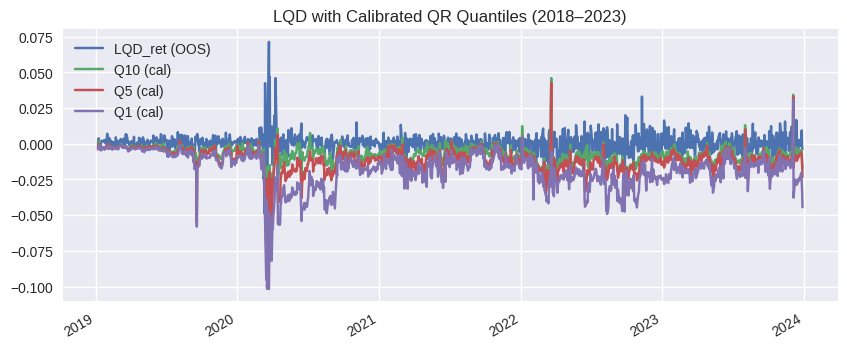

In [ ]:
# --- Rolling quantile calibration (additive offset) ---
# Uses residuals r_t = y_t - yhat_t; delta_t = Q_tau(r_{t-K:t-1}); yhat_cal_t = yhat_t + delta_t

CAL_WIN = 126        # ~6 months calibration window
MIN_OBS = 60         # minimum residuals to compute an offset

def calibrate_quantiles(y_true: pd.Series, pred_panel: pd.DataFrame, taus, win=CAL_WIN, min_obs=MIN_OBS):
    calibrated = {}
    for tau in taus:
        qname = f'Q{int(tau*100)}'
        # residuals between realized and model prediction
        res = (y_true - pred_panel[qname]).astype(float)
        # rolling residual tau-quantile, shifted so we don't peek
        delta = res.rolling(win, min_periods=min_obs).quantile(tau).shift(1)
        yhat_cal = pred_panel[qname] + delta
        # backfill initial NaNs with zero to keep series full (or use first valid offset)
        yhat_cal = yhat_cal.fillna(0.0 + pred_panel[qname])
        calibrated[qname] = yhat_cal
    return pd.DataFrame(calibrated, index=pred_panel.index)

pred_panel_cal = calibrate_quantiles(y_oos, pred_panel, QUANTILES, win=CAL_WIN, min_obs=MIN_OBS)

# (Optional) enforce non-crossing: sort each row so Q1 ≤ Q5 ≤ Q10
cols = [f'Q{int(t*100)}' for t in sorted(QUANTILES)]
pred_panel_cal[cols] = np.sort(pred_panel_cal[cols].values, axis=1)

# --- Re-check hit rates after calibration ---
for tau in QUANTILES:
    q = f'Q{int(tau*100)}'
    yhat = pred_panel_cal[q].astype(float)
    good = np.isfinite(yhat.values)
    v = (y_oos.values[good] < yhat.values[good]).sum()
    T = good.sum()
    print(f"[CAL] {q}: hit rate = {v/T:.3%} (target {tau:.1%}) | T={T}")

# --- Plot OOS returns vs CALIBRATED quantiles ---
fig, ax = plt.subplots()
y_oos.plot(ax=ax, label='LQD_ret (OOS)')
for tau in QUANTILES:
    q = f'Q{int(tau*100)}'
    pred_panel_cal[q].plot(ax=ax, label=f'{q} (cal)')
ax.set_title('LQD with Calibrated QR Quantiles (2018–2023)')
ax.legend(); ax.grid(True); plt.show()


This calibrates each quantile by adding a rolling residual quantile offset so the recent hit rate matches the target.

### Student C: extension of a DCC-GARCH framework with funding stress indicators acting as regime change detectors


Dynamical Conditional Correlation generalized autoregressive conditional heteroskedasticity (DCC-GARCH) is a model capable of estimating large time-varying covariance matrices. It does this by using estimating volatilities individually for each asset using GARCH for each separate time series.

The DCC (Dynamic Conditional Correlation) component is what makes the model "integrated" and powerful. It models how the correlations between these assets change over time. In a stable market, the correlation between stocks and bonds might be low or even negative. But during a market crisis, the correlation between almost all assets tends to spike towards 1 which is usually called a correlation spike.

In our case we will model use market sector tracker ETFs and market stress indicators as data for our correlation modeling, the idea is to be able to infer when the probability of correlation spikes are higher ahead of time. The data we are using are:

#### Sector tracking ETFs:
- XLY: Consumer Discretionary
- XLP: Consumer Staples
- XLE: Energy
- XLF: Financials
- XLV: Health Care
- XLI: Industrials
- XLB: Materials
- XLK: Technology
- XLU: Utilities

#### Market stress indicators [1](https://fred.stlouisfed.org/)

- TED: Treasury-Eurodollar spread (This one has been discontinued by FRED in favour of Secured Overnight Financing Rate (SOFR) )
- SOFR: Secured Overnight Financing Rate
- DFF: Federal Funds Effective Rate
- NFCI: Chicago Fed National Financial Conditions Index
- STLFSI4: St. Louis Fed Financial Stress Index
- VIX:CBOE Volatility Index


The difference between SOFR and DFF can be taken as a proxy of cross currency basis since it indicates dollar liquidity in the repo market. Adding these market indicators, builds on top of the materials provided by WQU.

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model
from fredapi import Fred

plt.rcParams["figure.figsize"] = (10,4)
fred = Fred(api_key='6caf186362e54dbfc3d2be7972c1e3df')
tickers_yahoo = ['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU',"^VIX"]
tikers_stress= ['TEDRATE', 'SOFR', 'DFF', 'NFCI', 'STLFSI4']
tickers = tickers_yahoo + tikers_stress
tickers=tickers+['SOFR_FFS_Spread']

## Function to download the data based on the starting and end dates
def data_for_dcc(start='2018-01-01', end='2023-12-31'):
  prices  = yf.download(tickers_yahoo, start=start, end=end,progress=False)['Close']
  # TED SPREAD Data
  ted_spread = fred.get_series('TEDRATE',observation_start=start,observation_end=end)
  # Get the SOFR and Federal Funds Rate data (Their difference will be a cross currency basis proxy)
  sofr = fred.get_series('SOFR',observation_start=start,observation_end=end)
  fed_funds_rate = fred.get_series('DFF',observation_start=start,observation_end=end)
  nfci_rate = fred.get_series('NFCI',observation_start=start,observation_end=end)
  stlfsi4_rate = fred.get_series('STLFSI4',observation_start=start,observation_end=end)
  # Combine the series into a single DataFrame
  rates = pd.concat([ted_spread,sofr, fed_funds_rate,nfci_rate,stlfsi4_rate], axis=1)
  rates.columns = ['TEDRATE','SOFR', 'DFF','NFCI','STLFSI4']
  # Calculate the SOFR-FFS spread
  rates['SOFR_FFS_Spread'] = rates['SOFR'] - rates['DFF']
  # returns
  factor_rets    = 100 * prices.interpolate(method='linear', axis=0).pct_change()
  rate_rets =  rates.interpolate(method='linear', axis=0)
  rets = pd.concat([factor_rets, rate_rets], axis=1).dropna()
  return rets
rets=data_for_dcc()

After obtaining the data we run a $GARCH(1,1)$ model with a Gaussian error term. then  we standardise the residuals,and collect the results in a dataframe.


In [ ]:
# Fit GARCH(1,1) to each series and collect standardized residuals
std_resid = pd.DataFrame(index=rets.index, columns=rets.columns)
for tkr in tickers :
    fit = arch_model(rets[tkr], vol='GARCH', p=1, q=1).fit(disp="off")
    std_resid[tkr] = fit.resid / fit.conditional_volatility

In [ ]:
# Simple DCC(1,1) log‑likelihood and parameter search
def dcc_loglik(params, eps):
    a, b = params                       # 1  unpack $\alpha$ and $\beta$ (the only DCC params)
    if a <= 0 or b <= 0 or a + b >= 1:  # 2  coarse stationarity/positivity check
        return np.inf                   #    infeasible → infinite loss

    T, N        = eps.shape             # 3  sample length T and #assets N
    Qbar        = eps.cov().values      # 4  unconditional correlation of shocks
    Q_prev      = Qbar.copy()           # 5  initialise recursion at Qbar
    loglike     = 0.0                   # 6  accumulator for (−2)·log‑likelihood

    for t in range(1, T):               # 7  walk through time
        e_prev = eps.iloc[t-1].values[:, None]         # 8  $\epsilon_{t‑1}$ column‑vector
        Q_t    = (1-a-b)*Qbar + a*e_prev@e_prev.T + b*Q_prev   # 9  DCC recursion

        d      = np.sqrt(np.diag(Q_t))  # 10 diagonal of $Q_t$ → std‑dev vector
        R_t    = Q_t / d[:,None] / d[None,:]           # 11 convert $Q_t$ → correlation
        Q_prev = Q_t                    # 12 roll $Q_t$ forward

        loglike += np.log(np.linalg.det(R_t)) + \
                   eps.iloc[t] @ np.linalg.inv(R_t) @ eps.iloc[t]   # 13 contrib.

    return 0.5*loglike                  # 14 QMLE objective (minimiser wants small)


from scipy.optimize import minimize
opt = minimize(dcc_loglik, x0=[0.05, 0.90],
               args=(std_resid,), bounds=[(1e-3,0.99)]*2)

a_dcc, b_dcc = opt.x
print(f"DCC alpha={a_dcc:.3f},  beta={b_dcc:.3f},  persistence={a_dcc+b_dcc:.3f}")

DCC alpha=0.050,  beta=0.900,  persistence=0.950


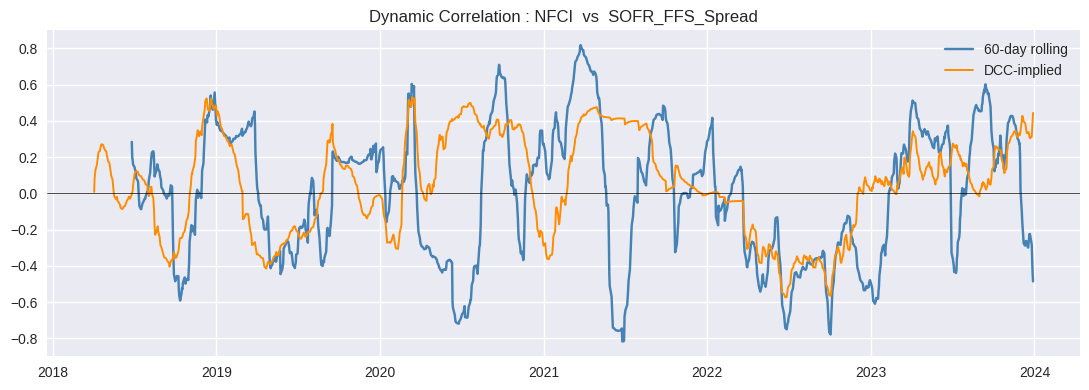

In [ ]:
# 1. Reconstruct the entire DCC correlation series for a chosen pair
def dcc_corr_series(eps, a, b, i, j):
    """Return a pd.Series with the DCC-implied correlation ρ_{ij,t}."""
    T      = len(eps)
    Q_bar  = eps.cov().values
    Q_prev = Q_bar.copy()
    rho    = np.empty(T)

    for t in range(T):
        if t > 0:
            e_prev = eps.iloc[t-1].values[:, None]
            Q_t    = (1-a-b)*Q_bar + a*e_prev@e_prev.T + b*Q_prev
        else:
            Q_t = Q_prev                       # at t=0 use Q̄

        d = np.sqrt(np.diag(Q_t))
        R_t = Q_t / d[:,None] / d[None,:]
        rho[t] = R_t[i, j]
        Q_prev = Q_t                           # roll forward

    return pd.Series(rho, index=eps.index)

pair   = ('NFCI', 'SOFR_FFS_Spread')
i, j   = tickers.index(pair[0]), tickers.index(pair[1])
dcc_r  = dcc_corr_series(std_resid, a_dcc, b_dcc, i, j)
roll_r = rets[pair[0]].rolling(60).corr(rets[pair[1]])

# 2. One clear plot: model vs naïve rolling estimate
plt.figure(figsize=(11,4))
plt.plot(roll_r,  label='60-day rolling',  color='steelblue')
plt.plot(dcc_r,   label='DCC-implied',     color='darkorange', linewidth=1.4)
plt.title(f"Dynamic Correlation : {pair[0]}  vs  {pair[1]}")
plt.axhline(0, color='k', lw=.5); plt.legend(); plt.tight_layout()
plt.show()


A cascade effect in financial markets describes a chain reaction where a shock to one part of the system rapidly spreads to others, creating a self-reinforcing loop of instability. This process often begins with a volatility shock—a sudden, sharp increase in market uncertainty, often triggered by an unexpected event.

A good proxy for this is the VIX which is a measure of the expected volatility of the market as a whole, when it is big the markets are quite volatile which usually means it is moving as a whole and correlations are close to one. We observe our DCC indicator (which measures the correlation between NFCI and our cross currency proxy) seems to be able to predict ahead of time when spikes in the vix will be present, we see that from 2023 the indicator breaks down, this is most likely due to the Fed changing its economic policies and entering into a high interest rate regime which had not been seen in many years [3](https://www.congress.gov/crs-product/IN12388#:~:text=The%20Federal%20Reserve%20(Fed)%20responded,the%20highest%20target%20since%202001.), other correlation pairs were considered but this is the one we found gave the best predictions for low interest rates environments.


Text(0.5, 1.0, 'Dynamic Correlation vs. VIX Index')

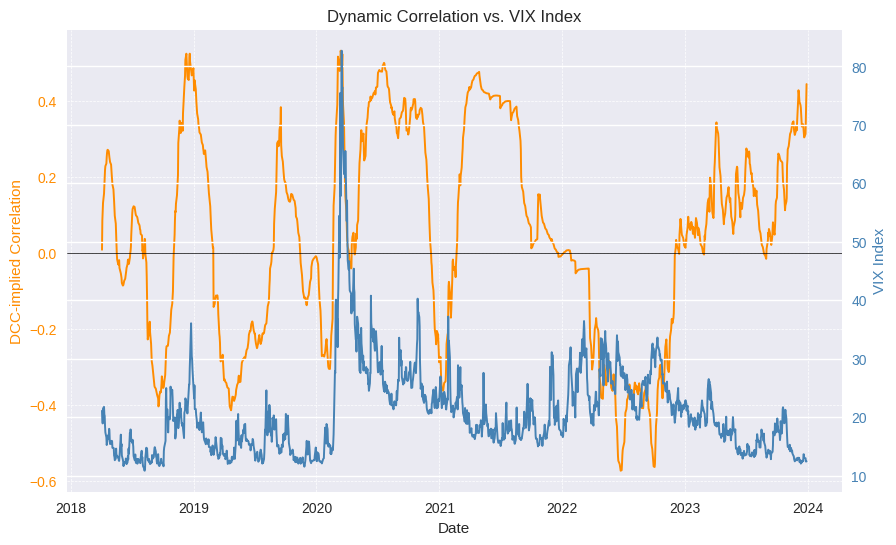

In [ ]:
vix_clipped = vix.loc[rets.index[0]:rets.index[-1]] # yf.download("^VIX", start=rets.index[0], end=rets.index[-1],progress=False)['Close']
# Create a single plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot DCC on the first y-axis
color = 'darkorange'
ax1.set_xlabel('Date')
ax1.set_ylabel('DCC-implied Correlation', color=color)
ax1.plot(dcc_r.index, dcc_r, label='DCC-implied Correlation', color=color, linewidth=1.4)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(0, color='k', lw=.5)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Create a second y-axis for VIX
ax2 = ax1.twinx()
color = 'steelblue'
ax2.set_ylabel('VIX Index', color=color)
ax2.plot(vix_clipped.index, vix_clipped, label='VIX Index', color=color, linewidth=1.4)
ax2.tick_params(axis='y', labelcolor=color)

# Add a single title for the plot
plt.title('Dynamic Correlation vs. VIX Index')


This shock immediately leads to a correlation spike, as a sudden "risk-off" sentiment causes investors to sell all assets indiscriminately, driving their prices down in unison. Assets that were once uncorrelated or negatively correlated now move together, eliminating the benefits of diversification.

The increased volatility and correlation then trigger a funding freeze. As lenders become hesitant to extend credit due to heightened risk, market liquidity dries up. This forces institutions to sell assets to meet their funding needs, which in turn drives prices down further, causing even more volatility. This completes the feedback loop, as the funding freeze exacerbates the initial volatility shock. This cascade demonstrates how seemingly distinct market dynamics are deeply interconnected, creating a vicious cycle that can lead to a systemic crisis.


## Global Systemic Risk Indicator

By integrating the results of the different generalizations we considered, and 
expanding upon the work of student A, we will create a Global Systemic Risk
Indicator 

$$\text{GSRI} = \alpha SRI + \beta DCC$$

We will use scipy's curve fit to produce adequate $\alpha,\beta$ in such 
a way that the indicator becomes not only good at predicting possible economic 
crisis, by going with a simple linear combination of the different indicators 
we are able to produce an easy to interpret risk indicator, according to Molnar 
when it comes to algorithms that can have big repercusions, it's best to have 
interpretable models so experts can know in what situations they break down.


In [ ]:
start_date = "2018-04-03"
end_date = "2023-12-31"

# gather data
student_a_indicator = SRI.loc[start_date:end_date]
student_b_indicator = pd.Series(data = np.zeros(student_a_indicator.shape), index=student_a_indicator.index) 
student_c_indicator = dcc_r

In [ ]:
# find coefficients of this global indicator linear function
def global_SRI(input, alpha, beta, gamma):
  student_a = input.iloc[:,0].to_numpy()
  student_b = input.iloc[:,1].to_numpy()
  student_c = input.iloc[:,2].to_numpy()
  
  return alpha * student_a + beta * student_b + gamma * student_c

In [ ]:
aggregated_data_all_students = pd.concat([student_a_indicator, student_b_indicator, student_c_indicator], axis=1)

# calibrate function
popt_global, pcov_global, infodict_global, mesg_global, ier_global = curve_fit(global_SRI, aggregated_data_all_students, vix_clipped/100, bounds=(0.4, 1),sigma=1e-6, full_output=True)
popt_global # alpha, beta, gamma

array([1.        , 0.87914484, 0.4       ])

The result from the optimization indicate that the most important indicator is 
the one from student A based on the PCA monitoring framework 

In [ ]:
# stddev of our coefficients "popt_global"
perr_global = np.sqrt(np.diag(pcov_global))
perr_global

array([0.01869481, 0.        , 0.01203404])

In [ ]:
# Global SRI
alpha_global = popt_global[0]
beta_global = popt_global[1] 
gamma_global = popt_global[2]

signal_indicator = alpha_global * student_a_indicator + beta_global * student_b_indicator + gamma_global * student_c_indicator

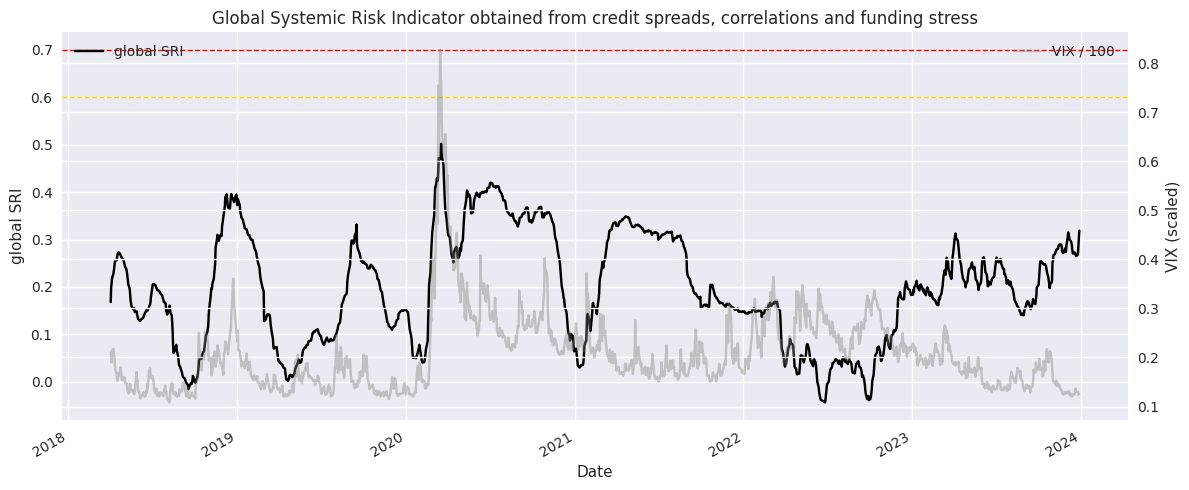

In [ ]:
# plot signal indicator against vix
fig, ax1 = plt.subplots(figsize=(12,5))

signal_indicator.plot(ax=ax1, color="k", label="global SRI")
ax1.axhline(0.3, ls="--", color="gold", lw=1)
ax1.axhline(0.4, ls="--", color="red", lw=1)
ax1.set(ylabel="global SRI", title="Global Systemic Risk Indicator obtained from credit spreads, correlations and funding stress")
ax2 = ax1.twinx()
(vix_clipped/100).plot(ax=ax2, color="tab:gray", alpha=0.4, label="VIX / 100")
ax2.set_ylabel("VIX (scaled)")
ax1.legend(loc="upper left"); ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

Our integrated approach is able to signal abrupt movements in market volatility ahead of time, giving us the ability to prevent losses, eventhough it smooths some of the peaks a bit too much, so we miss small abrupt movements in the VIX when using our indicator. We can see our indicator breaks down at the end of the 2022 this is because the contribution of our DCC model based on the SOFR and Federal interest rate took a massive regime shift, one that it's historical as 
it changed the macro environment into one that had not been seen in decades (see the article by Irvine D). As we will see next allowing our model no lower bound on the importance of this  SOFR and Federal interest rate indicator based on DCC gets us better tracking of the VIX but we loose our predictive power as the spikes are not seen ahead of time 

In [ ]:
# calibrate function
popt_global, pcov_global, infodict_global, mesg_global, ier_global = curve_fit(global_SRI, aggregated_data_all_students, vix_clipped/100, bounds=(0, 1),sigma=1e-6, full_output=True)
popt_global # alpha, beta, gamma

array([1.        , 0.80739945, 0.03163214])

In [ ]:
# Global SRI
alpha_global = popt_global[0]
beta_global = popt_global[1] 
gamma_global = popt_global[2]

signal_indicator = alpha_global * student_a_indicator + beta_global * student_b_indicator + gamma_global * student_c_indicator

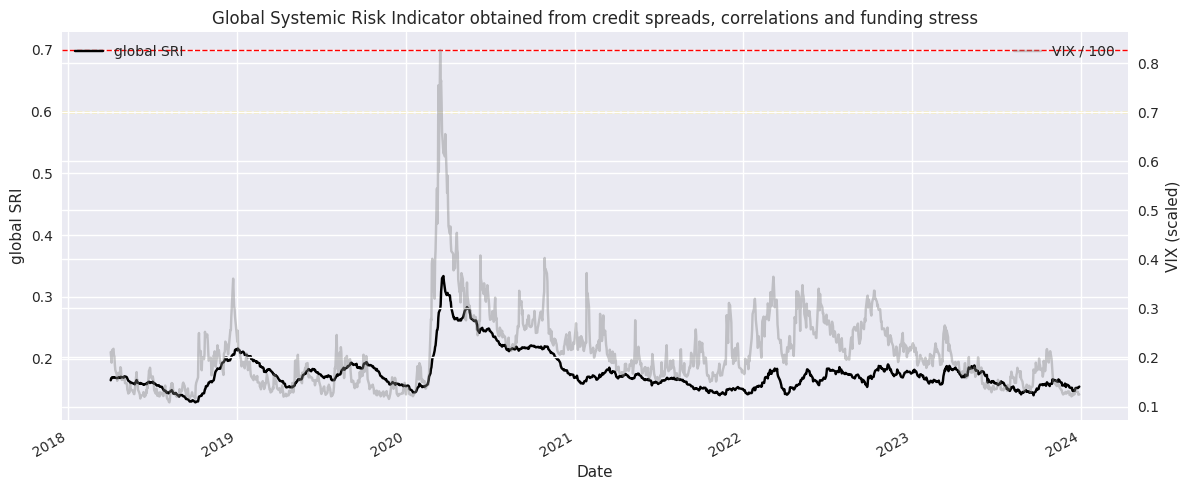

In [ ]:
# plot signal indicator against vix
fig, ax1 = plt.subplots(figsize=(12,5))

signal_indicator.plot(ax=ax1, color="k", label="global SRI")
ax1.axhline(0.25, ls="--", color="gold", lw=1)
ax1.axhline(0.3, ls="--", color="red", lw=1)
ax1.set(ylabel="global SRI", title="Global Systemic Risk Indicator obtained from credit spreads, correlations and funding stress")
ax2 = ax1.twinx()
(vix_clipped/100).plot(ax=ax2, color="tab:gray", alpha=0.4, label="VIX / 100")
ax2.set_ylabel("VIX (scaled)")
ax1.legend(loc="upper left"); ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

The change in the macro environment and the fact that a similar macro is not seen in the data gives our indicator some trouble, the good news is that the interest rates cannot be high for a long time, in fact, how long they have been high is what makes the current economical situation so unusual. According to Moore S. the possibility of the Federal reserved lowering interest rates next month sits at around 91% , those interest rates will perhaps return the correlation of our indicator into it's normal regime, thus allowing us to use our indicator as the correlations are likely to go back to their usual pattern once interest rates come down

## Comparison with VAR model

In this section, we are going to compare our SRI with output prediction for ^VIX from a Vector AutoRegressive (VAR) model.

We are going to focus our attention to the period immediately before the spike in volatility that happened during the Covid crisis from approximately February to April 2020.

The crisis period February - April 2020 (included) will stand as our testing period.
The training period will cover the two previous years, from April 2018 to January 2020.

The VAR model will be composed of

- the ^VIX index itself, 
- the credit spreads as obtained from FRED (BBA10Y series), 
- the TED spread from FRED,
- the SOFR - FFS spread, from FRED as well.

In [ ]:
from statsmodels.tsa.api import VAR

In [ ]:
# gather data
ted_spread = rets["TEDRATE"]
sofr_ffs_spread = rets["SOFR_FFS_Spread"]
var_data = pd.concat([vix_clipped, spread_fred.loc[start_date:end_date], ted_spread, sofr_ffs_spread], axis=1)

print("series included in the VAR model for ^VIX: ", var_data.columns)

,^VIX,Credit Spread from FRED,TEDRATE,SOFR_FFS_Spread
2018-04-03,21.100000,0.0184,0.60,0.14
2018-04-04,20.059999,0.0185,0.64,0.05
2018-04-05,18.940001,0.0184,0.64,0.06
2018-04-06,21.490000,0.0184,0.64,0.06
2018-04-09,21.770000,0.0183,0.61,0.06
...,...,...,...,...
2020-01-27,18.230000,0.0204,0.25,-0.02
2020-01-28,16.280001,0.0204,0.23,-0.02
2020-01-29,16.389999,0.0205,0.25,-0.02
2020-01-30,15.490000,0.0208,0.22,-0.02


In [ ]:
training_start_date = "2018-04-03"
training_end_date = "2020-02-01"

var_data_training = var_data.loc[training_start_date : training_end_date]

In [ ]:
testing_start_date = "2020-02-02"
testing_end_date = "2020-05-01"

var_data_testing = var_data.loc[testing_start_date : testing_end_date]

,^VIX,Credit Spread from FRED,TEDRATE,SOFR_FFS_Spread
2020-02-03,17.969999,0.0210,0.20,0.00
2020-02-04,16.049999,0.0209,0.20,0.01
2020-02-05,15.150000,0.0207,0.20,0.00
2020-02-06,14.960000,0.0205,0.19,0.00
2020-02-07,15.470000,0.0205,0.20,0.00
...,...,...,...,...
2020-04-27,33.290001,0.0324,0.72,-0.01
2020-04-28,33.570000,0.0325,0.65,-0.03
2020-04-29,31.230000,0.0324,0.59,-0.03
2020-04-30,34.150002,0.0323,0.47,-0.01


We fit the `VAR` model from the `statsmodels` package in Python.

In [ ]:
var_model = VAR(var_data_training)
fitted_var_model = var_model.fit(maxlags=None, ic=None, method="ols", trend="c", verbose=True)

fitted_var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 28, Aug, 2025
Time:                     22:59:46
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -27.7384
Nobs:                     461.000    HQIC:                  -27.8471
Log likelihood:           3838.50    FPE:                7.50771e-13
AIC:                     -27.9177    Det(Omega_mle):     7.19064e-13
--------------------------------------------------------------------
Results for equation ^VIX
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                              1.487511         0.880004            1.690           0.091
L1.^VIX                            0.927616         0.019953           46.490           0.000
L1.Credit

Results are statistically acceptable.
The model was directed to select autonomously the number of lag terms for the VAR independent variables.

In [ ]:
lag_order = fitted_var_model.k_ar
print(f"VAR model was fitted with {lag_order} lag terms")

VAR model was fitted with 1 lag terms


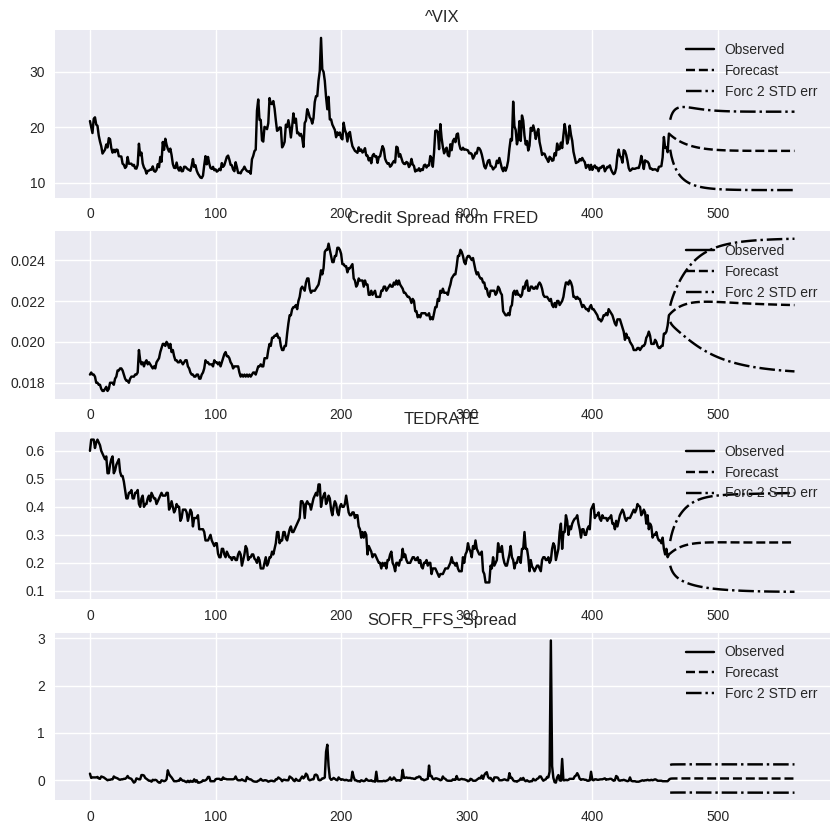

In [ ]:
# fitted_var_model.plot_forecast(steps=64, alpha=0.05, plot_stderr=True)
# plt.show()

In [ ]:
data_forecast = var_data_training.values[fitted_var_model.k_ar :]
#data_forecast.shape

(461, 4)

In [ ]:
pred = fitted_var_model.forecast(y=data_forecast, steps=var_data_testing.shape[0]+1)
pd.DataFrame(pred)
# extend index with business dates per USFederalHolidayCalendar
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
idx = pd.date_range(testing_start_date, testing_end_date, freq=us_bd)
df_forecast = pd.DataFrame(data=pred, index=idx, columns=var_data.columns)
df_forecast_vix = df_forecast.iloc[:,0].rename("^VIX VAR forecast")
# df_forecast_vix

2020-02-03    18.640695
2020-02-04    18.450905
2020-02-05    18.272151
2020-02-06    18.104234
2020-02-07    17.946625
                ...    
2020-04-27    15.751542
2020-04-28    15.749242
2020-04-29    15.747154
2020-04-30    15.745261
2020-05-01    15.743549
Freq: C, Name: ^VIX VAR forecast, Length: 64, dtype: float64

A graphic comparison of the output from the VAR model, the SRI, and the true path taken by ^VIX during the Feb - Apr 2020 testing period is presented below.

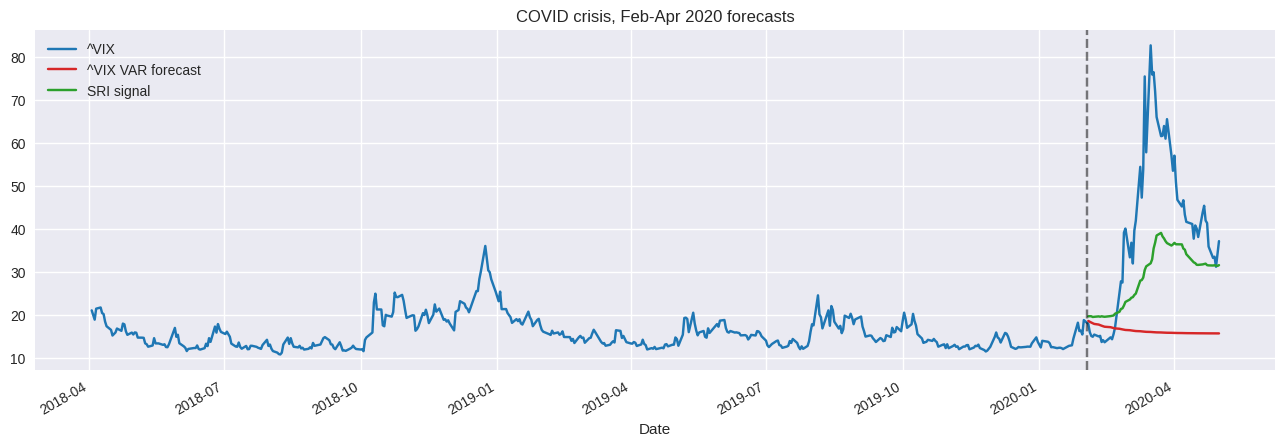

In [ ]:
# plot initial data with forecasted values 
plt.figure(figsize=(16, 5))
var_data.loc[training_start_date:testing_end_date, "^VIX"].plot(color='tab:blue')
df_forecast_vix.plot(color='tab:red',legend=True)
(signal_indicator.loc[testing_start_date:testing_end_date]*100).plot(color='tab:green', label="SRI signal", legend=True)
plt.axvline(x=testing_start_date, color="k", alpha=0.5, linestyle="--")
plt.legend()
plt.title("COVID crisis, Feb-Apr 2020 forecasts")
plt.show()

We see that the SRI performs better than the VAR model, although still quite not able of predicting the full intensity of the crisis.

### References

- FRED database, **https://fred.stlouisfed.org/series**, accessed on 25 August 2025
- Molnar, C. (2025). Interpretable Machine Learning:
A Guide for Making Black Box Models Explainable (3rd ed.).
christophm.github.io/interpretable-ml-book/
- Afzal, F., Haiying, P., Afzal, F., Mahmood, A., & Ikram, A. (2021). Value-at-Risk Analysis for Measuring Stochastic Volatility of Stock Returns: Using GARCH-Based Dynamic Conditional Correlation Model. SAGE Open, 11(1). https://doi.org/10.1177/21582440211005758 (Original work published 2021)
- Arısoy, Yakup Eser, Quantile Regressions: Estimating Moments of the Stock Return Distribution (July 19, 2023). Available at SSRN: https://ssrn.com/abstract=4515136 or http://dx.doi.org/10.2139/ssrn.4515136
- Yahoo Finance. (2025). Historical data for ETFs was obtained from https://finance.yahoo.com/ 
- SciPy 1.0: Fundamental Algorithms for Scientific Computing in Python. Nature Methods, 17(3), 261-272. DOI: 10.1038/s41592-019-0686-2
- Irvine, D. (2024) A new era of higher interest rates, Forbes. Available at: https://www.forbes.com/sites/danirvine/2024/04/30/a-new-era-of-higher-interest-rates/ 
-  Moore, S. (2025) Fed expected to cut interest rates, though inflation may be picking up, Forbes. Available at: https://www.forbes.com/sites/simonmoore/2025/08/16/fed-expected-to-cut-interest-rates-though-inflation-may-be-picking-up/ 